# Contrastive Learning on the MNIST Data Set

- **Problem**: Image classification for datasets with vast amounts of unlabeled data but very scarce labels and expensive labeling process (medical images).

- **Proposed Solution**: Contrastive Learning.

- **Brief Explanation**: 
    - Contrastive Learning is a self-supervised learning approach for pretraining. 
    - Images are mapped into a representation space where similar images are close to each other and dissimilar images are far apart.
    - After that the downstream task (usually classification) is performed.

- Based on https://arxiv.org/pdf/2002.05709

### Dataset
![mnist](images/mnist.jpg)

### So how do we get this mapping?
![simclr_architecture](images/simclr_architecture_scheme_annotated.png)
![simple_simclr_architecture](images/simple_simclr_architecture_new.png)

# 1 Imports

## 1.1 Importing Libraries

In [278]:
import numpy as np
import pandas as pd
import time, os, random, copy


In [279]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop, RandomResizedCrop, ColorJitter, GaussianBlur, RandomApply, RandomGrayscale


In [280]:
import matplotlib.pyplot as plt
%matplotlib inline

In [281]:
from sklearn.manifold import TSNE

## 1.2 Setting the Seed for Reproducibility

In [282]:
def set_seed(seed = 16):
    np.random.seed(seed)
    torch.manual_seed(seed)

# 2 Preparing the MNIST Data Set

## 2.1 Defining Transformations

In [283]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307), (0.3081))])

contrastive_transform = Compose(
    [RandomHorizontalFlip(), 
     RandomResizedCrop(size=28, scale=(0.8, 1.0)), 
     RandomApply([ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8), 
     RandomGrayscale(p=0.2), 
     GaussianBlur(kernel_size=9), 
     ToTensor(), 
     Normalize((0.1307,), (0.3081,))])

class CLTransformations(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        xi = self.transform(sample)
        xj = self.transform(sample)
        return xi, xj
    
contrastive_transform = CLTransformations(contrastive_transform)

- why those normalisations?
- create a table with parameters

## 2.2 Defining Dataset Size, Pretraining Batch Size and Validation Split 

In [284]:
dataset_size = 5000
pretraining_batch_size = 256
validation_split = 0.2

train_size = int((1 - validation_split) * dataset_size) # 80% of the data for training
valid_size = int(validation_split * dataset_size)       # 20% of the data for validation

## 2.3 Creating DataLoaders

In [285]:
# Creating the training and validation data loaders
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=contrastive_transform)
trainset = torch.utils.data.Subset(trainset, range(dataset_size))
trainset, valset = torch.utils.data.random_split(trainset, [train_size, valid_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=pretraining_batch_size,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=pretraining_batch_size, shuffle=False)

# Creating the test data loader
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=contrastive_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=pretraining_batch_size, shuffle=False)

# Defining the MNIST classes
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

## 2.4 Visualising the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


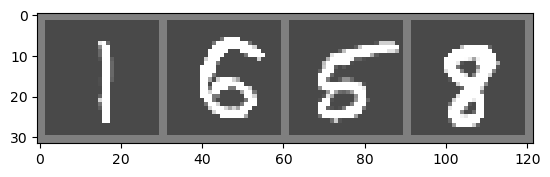

one   six   five  eight


In [286]:
# loading the data
show_batch_size = 4
show_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
show_trainloader = torch.utils.data.DataLoader(show_trainset, batch_size=show_batch_size,
                                          shuffle=True, num_workers=2)

show_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
show_testloader = torch.utils.data.DataLoader(show_testset, batch_size=show_batch_size,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine')

# getting random training images
dataiter = iter(show_trainloader)
images, labels = next(dataiter)

# show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(show_batch_size)))

- what does imshow do?

# 3 Contrastive Pretraining

## 3.1 Defining and Initialising the Model

### 3.1.1 Base Encoder and Projection Head

In [287]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.layers = nn.Sequential(
            self.fc1, nn.ReLU(),        # 800 -> 500
            self.fc2)                   # 500 -> 10

    def forward(self, x):
        x = self.layers(x)
        return x

class CLModel(nn.Module):
    def __init__(self):
        super(CLModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.projection_head = ProjectionHead(800, 500, 10)

    def forward(self, x):
        # CNN Base Encoder
        x = torch.relu(self.conv1(x))  
        x = torch.max_pool2d(x, 2, 2)  # 20x24x24 -> 20x12x12
        x = torch.relu(self.conv2(x))  # 20x12x12 -> 50x8x8
        x = torch.max_pool2d(x, 2, 2)  # 50x8x8 -> 50x4x4
        x = x.view(-1, 4 * 4 * 50)     # 50x4x4 -> 800

        # Projection Head
        x = self.projection_head(x)                
        return x
    
    def forward_no_projection_head(self, x):
        # CNN Base Encoder
        x = torch.relu(self.conv1(x))  
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        return x

![cnn_architecture](images/simple_cnn_architecture_new.png)

### 3.1.2 Contrastive Loss

- Encourages "positive pairs", i.e. image representations from the same original image, to be close to each other.
- Encourages "negative pairs", i.e. image representations from different original images, to be far apart from each other.

$
L(i, j) = -\log\left(\frac{\exp(\text{sim}(z_i, z_j) / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k) / \tau)}\right)
$

Where:
- $z_i$ and $z_j$ are the representations from the same original image.
- $\text{sim}(z_i, z_j)$ is the cosine similarity between the representations.
- $\tau$ is the temperature parameter.
- The sum in the denominator includes all representations except for the positive pair.

In [288]:
def contrastive_loss(hi, hj, temperature=0.5):
    # concatenate two sets of features
    h = torch.cat([hi, hj], dim=0)

    # calculate cosine similarity
    cos_sim = F.cosine_similarity(h.unsqueeze(1), h.unsqueeze(0), dim=2)

    # remove self-similarity form the matrix
    cos_sim = cos_sim.masked_fill(torch.eye(cos_sim.shape[0]).bool(), -1e9)

    # for each image, find the positive pair
    positive_pairs = torch.cat([torch.arange(hi.shape[0], 2*hi.shape[0]), torch.arange(hi.shape[0])], dim=0)

    # compute the InfoNCE loss
    loss = F.cross_entropy(cos_sim / temperature, positive_pairs)
    return loss

### 3.1.3 Initialising Model

In [289]:
model = CLModel()

### 3.1.4 Initialising the Optimiser

In [290]:
learning_rate = 0.001
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

## 3.2 Training

In [291]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(500):
    model.train()
    running_loss = 0.0
    batch = 0

    for (xi, xj), _ in trainloader:
        batch += 1

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward 
        hi, hj = model(xi), model(xj)
        loss = contrastive_loss(hi, hj)

        # loss
        running_loss += loss.item()

        # backward + optimise
        loss.backward()
        optimiser.step()

    avg_train_loss = running_loss / batch
    train_losses.append(avg_train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (xi, xj), _ in valloader:
            hi, hj = model(xi), model(xj)
            loss = contrastive_loss(hi, hj)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(valloader)
    val_losses.append(avg_val_loss)

    # print statistics
    print(f'Epoch {epoch}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    # early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        #torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping')
            break

Epoch 0, Train Loss: 5.321903049945831, Val Loss: 4.985925674438477
Epoch 1, Train Loss: 4.909535199403763, Val Loss: 4.854945778846741
Epoch 2, Train Loss: 4.820014238357544, Val Loss: 4.785063982009888
Epoch 3, Train Loss: 4.745616644620895, Val Loss: 4.731063723564148
Epoch 4, Train Loss: 4.718455195426941, Val Loss: 4.712180137634277
Epoch 5, Train Loss: 4.699855923652649, Val Loss: 4.688030362129211
Epoch 6, Train Loss: 4.67709556221962, Val Loss: 4.661253809928894
Epoch 7, Train Loss: 4.654333025217056, Val Loss: 4.6403573751449585
Epoch 8, Train Loss: 4.635214477777481, Val Loss: 4.636456370353699
Epoch 9, Train Loss: 4.611314177513123, Val Loss: 4.614588499069214
Epoch 10, Train Loss: 4.601115852594376, Val Loss: 4.613850355148315
Epoch 11, Train Loss: 4.597567141056061, Val Loss: 4.585377812385559
Epoch 12, Train Loss: 4.581654280424118, Val Loss: 4.583718299865723
Epoch 13, Train Loss: 4.575073748826981, Val Loss: 4.572857856750488
Epoch 14, Train Loss: 4.563926428556442, Val

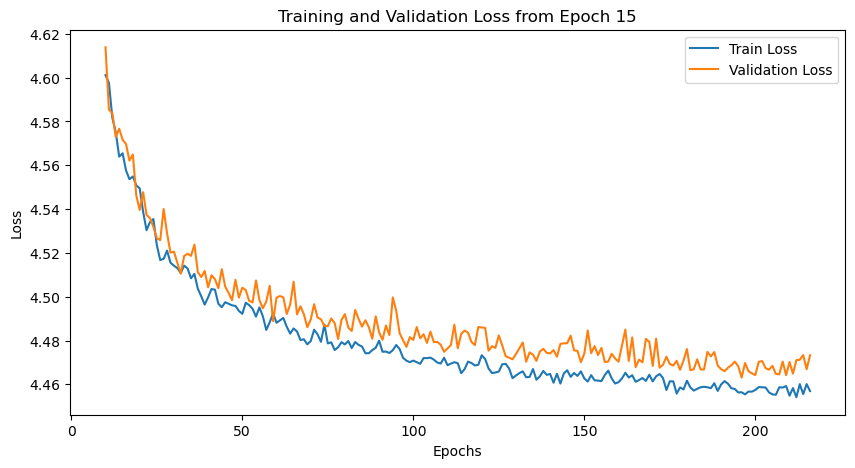

In [292]:
# Visualize the losses
plt.figure(figsize=(10, 5))

# Only plot losses if there are at least 10 epochs
if len(train_losses) > 10 and len(val_losses) > 10:
    plt.plot(range(10, len(train_losses)), train_losses[10:], label='Train Loss')
    plt.plot(range(10, len(val_losses)), val_losses[10:], label='Validation Loss')

plt.title('Training and Validation Loss from Epoch 15')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4 Linear Classification

## 4.1 With Contrastive Pretraining

### 4.1.1 Loading the Pretrained Data

In [384]:
def extract_features(dataloader, model):
    features = []
    labels = []

    with torch.no_grad():
        for xi, target in dataloader:
            feature = model.forward_no_projection_head(xi)
            features.append(feature)
            labels.append(target)

    return torch.cat(features), torch.cat(labels)

In [385]:
linear_batch_size = 256

In [386]:
linear_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

In [387]:
# Load datasets
linear_dataset = datasets.MNIST('./data', train=True, download=True, transform=linear_transforms)
train_size = int((1-valid_size) * len(linear_dataset))
val_size = len(linear_dataset) - train_size
linear_trainset, linear_valset = torch.utils.data.random_split(linear_dataset, [train_size, val_size])

# Create data loaders
linear_trainloader = DataLoader(linear_dataset, batch_size=linear_batch_size, shuffle=True)
linear_valloader = DataLoader(linear_valset, batch_size=linear_batch_size, shuffle=False)

# Extract features
train_features, train_labels = extract_features(linear_trainloader, model)
linear_trainset = torch.utils.data.TensorDataset(train_features, train_labels)
linear_trainloader = DataLoader(linear_trainset, batch_size=linear_batch_size, shuffle=True)

val_features, val_labels = extract_features(linear_valloader, model)
linear_valset = torch.utils.data.TensorDataset(val_features, val_labels)
linear_valloader = DataLoader(linear_valset, batch_size=linear_batch_size, shuffle=False)

# Load the test dataset
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=linear_transforms)
testloader = DataLoader(test_dataset, batch_size=linear_batch_size, shuffle=False)
test_features, test_labels = extract_features(testloader, model)
linear_testset = torch.utils.data.TensorDataset(test_features, test_labels)
testloader = DataLoader(linear_testset, batch_size=linear_batch_size, shuffle=False)


### 4.1.2 Initialising the Linear Classifier and Optimiser

In [388]:
linear_learning_rate = 0.1

In [389]:
linear_classifier = nn.Linear(4 * 4 * 50, 10)
linear_optimiser = optim.Adam(linear_classifier.parameters(), lr=linear_learning_rate)

### 4.1.3 Linear Classification With Contrastive Pretraining

In [390]:
linear_train_losses = []
linear_val_losses = []
linear_best_val_loss = float('inf')
linear_patience = 20
linear_patience_counter = 0
linear_val_accuracies = []
linear_train_accuracies = []

for epoch in range(100):
    linear_classifier.train()
    linear_running_loss = 0.0
    linear_total = 0
    linear_correct = 0

    for batch, data in enumerate(linear_trainloader, 0):
        features, labels = data

        # zero the parameter gradients
        linear_optimiser.zero_grad()

        # forward 
        outputs = linear_classifier(features)

        # loss
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # accuracy
        _, predicted = torch.max(outputs, 1)
        linear_total += labels.size(0)
        linear_correct += (predicted == labels).sum().item()

        # backward
        loss.backward()
        running_loss += loss.item()

        # optimise
        linear_optimiser.step()

    linear_avg_train_loss = linear_running_loss / len(linear_trainloader)
    linear_train_losses.append(linear_avg_train_loss)

    # Training accuracy
    linear_train_accuracy = 100 * linear_correct / linear_total
    linear_train_accuracies.append(linear_train_accuracy)

    # validation
    linear_classifier.eval()
    linear_val_loss = 0.0
    linear_val_correct = 0
    linear_val_total = 0

    with torch.no_grad():
        for features, labels in linear_valloader:
            outputs = linear_classifier(features)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            linear_val_loss += loss.item()

            # validation accuracy
            _, val_predicted = torch.max(outputs, 1)
            linear_val_total += labels.size(0)
            linear_val_correct += (val_predicted == labels).sum().item()
        
    linear_avg_val_loss = linear_val_loss / len(linear_valloader)
    linear_val_losses.append(linear_avg_val_loss)

    # Training accuracy
    linear_train_accuracy = 100 * linear_correct / linear_total
    linear_train_accuracies.append(linear_train_accuracy)

    # validation accuracy
    linear_val_accuracy = 100 * linear_val_correct / linear_val_total
    linear_val_accuracies.append(linear_val_accuracy)

    # print statistics
    accuracy = 100 * linear_correct / linear_total
    print(f'Epoch {epoch}, Train Loss: {linear_avg_train_loss:.4f}, Val Loss: {linear_avg_val_loss:.4f}, Train Accuracy: {accuracy:.2f}%, Val Accuracy: {linear_val_accuracy:.2f}%')

    # early stopping
    if linear_avg_val_loss < linear_best_val_loss:
        linear_best_val_loss = linear_avg_val_loss
        linear_patience_counter = 0
        #torch.save(linear_classifier.state_dict(), 'best_linear_model.pth')
    else:
        linear_patience_counter += 1
        if linear_patience_counter >= linear_patience:
            print('Early stopping')
            break

Epoch 0, Train Loss: 0.0000, Val Loss: 0.2502, Train Accuracy: 95.41%, Val Accuracy: 97.30%
Epoch 1, Train Loss: 0.0000, Val Loss: 0.2030, Train Accuracy: 97.08%, Val Accuracy: 98.29%
Epoch 2, Train Loss: 0.0000, Val Loss: 0.2225, Train Accuracy: 97.69%, Val Accuracy: 98.06%
Epoch 3, Train Loss: 0.0000, Val Loss: 0.2646, Train Accuracy: 97.99%, Val Accuracy: 97.75%
Epoch 4, Train Loss: 0.0000, Val Loss: 0.1816, Train Accuracy: 97.99%, Val Accuracy: 98.55%
Epoch 5, Train Loss: 0.0000, Val Loss: 0.3192, Train Accuracy: 98.31%, Val Accuracy: 97.75%
Epoch 6, Train Loss: 0.0000, Val Loss: 0.2219, Train Accuracy: 98.34%, Val Accuracy: 98.48%
Epoch 7, Train Loss: 0.0000, Val Loss: 0.2505, Train Accuracy: 98.44%, Val Accuracy: 98.31%
Epoch 8, Train Loss: 0.0000, Val Loss: 0.4132, Train Accuracy: 98.47%, Val Accuracy: 97.66%
Epoch 9, Train Loss: 0.0000, Val Loss: 0.1459, Train Accuracy: 98.59%, Val Accuracy: 98.97%
Epoch 10, Train Loss: 0.0000, Val Loss: 0.2083, Train Accuracy: 98.71%, Val Accu

In [391]:
# Calculate test set accuracy
linear_classifier.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for features, labels in testloader:
        features = features.view(features.size(0), -1)
        outputs = linear_classifier(features)
        
        # Calculate test accuracy
        _, test_predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (test_predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 98.60%


### 4.1.4 Visualisation

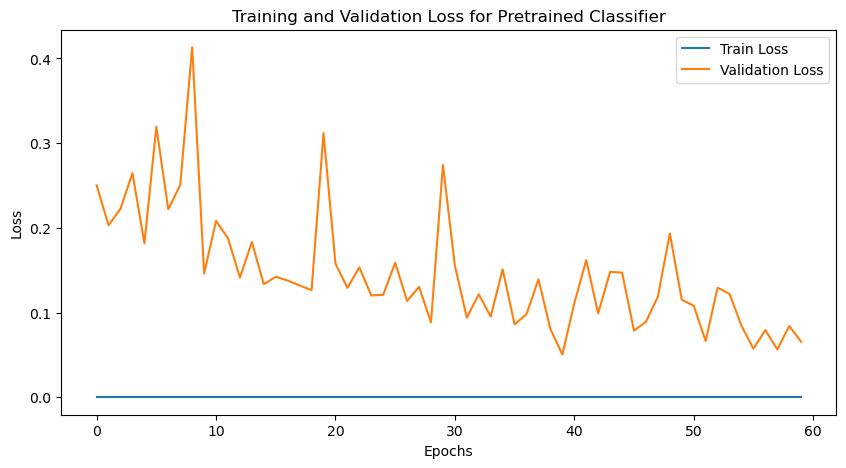

In [392]:
# Visualization of training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(linear_train_losses, label='Train Loss')
plt.plot(linear_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss for Pretrained Classifier')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

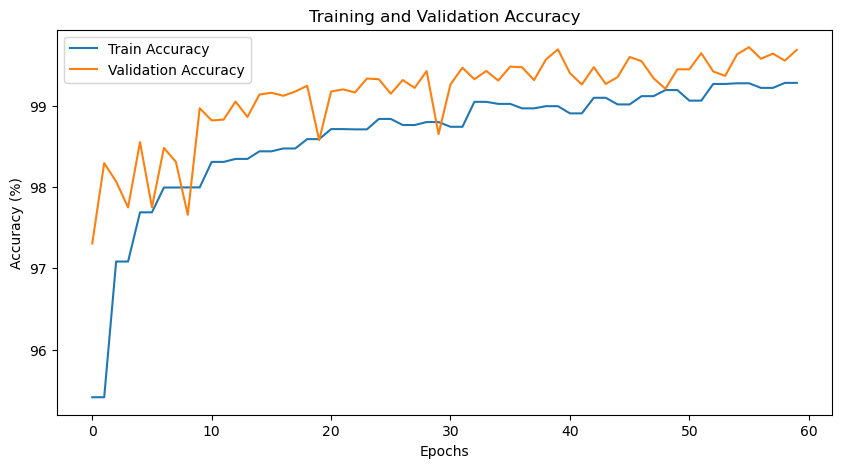

In [393]:
# Visualization of training and validation accuracy
num_epochs = min(len(linear_train_accuracies), len(linear_val_accuracies))
plt.figure(figsize=(10, 5))
plt.plot(linear_train_accuracies[:num_epochs], label='Train Accuracy')
plt.plot(linear_val_accuracies[:num_epochs], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## 4.2 With Contrastive Pretraining on Half the Data

### 4.2.1 Loading Half the Data

In [394]:
subset_proportion = 0.5

In [395]:
linear_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])


In [396]:
# Load datasets
linear_dataset = datasets.MNIST('./data', train=True, download=True, transform=linear_transforms)
subset_size = int(subset_proportion * len(linear_dataset))

# Create a subset of the dataset
linear_dataset = torch.utils.data.Subset(linear_dataset, list(range(subset_size)))

# Split into training and validation sets
train_size = int((1-valid_size) * len(linear_dataset))
val_size = len(linear_dataset) - train_size
linear_trainset, linear_valset = torch.utils.data.random_split(linear_dataset, [train_size, val_size])

# Create data loaders
linear_trainloader = DataLoader(linear_dataset, batch_size=linear_batch_size, shuffle=True)
linear_valloader = DataLoader(linear_valset, batch_size=linear_batch_size, shuffle=False)

# Extract features
train_features, train_labels = extract_features(linear_trainloader, model)
linear_trainset = torch.utils.data.TensorDataset(train_features, train_labels)
linear_trainloader = DataLoader(linear_trainset, batch_size=linear_batch_size, shuffle=True)

val_features, val_labels = extract_features(linear_valloader, model)
linear_valset = torch.utils.data.TensorDataset(val_features, val_labels)
linear_valloader = DataLoader(linear_valset, batch_size=linear_batch_size, shuffle=False)

# Load the test dataset
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=linear_transforms)
testloader = DataLoader(test_dataset, batch_size=linear_batch_size, shuffle=False)
test_features, test_labels = extract_features(testloader, model)
linear_testset = torch.utils.data.TensorDataset(test_features, test_labels)
testloader = DataLoader(linear_testset, batch_size=linear_batch_size, shuffle=False)


### 4.2.2 Initialising the Linear Classifier and Optimiser

In [397]:
linear_learning_rate = 0.1
linear_classifier = nn.Linear(4 * 4 * 50, 10)
linear_optimiser = optim.Adam(linear_classifier.parameters(), lr=linear_learning_rate)

### 4.2.3 Linear Classification With Contrastive Pretraining on Half the Data

In [398]:
linear_train_losses = []
linear_val_losses = []
linear_best_val_loss = float('inf')
linear_patience = 20
linear_patience_counter = 0
linear_val_accuracies = []
linear_train_accuracies = []

for epoch in range(100):
    linear_classifier.train()
    linear_running_loss = 0.0
    linear_total = 0
    linear_correct = 0

    for batch, data in enumerate(linear_trainloader, 0):
        features, labels = data

        # zero the parameter gradients
        linear_optimiser.zero_grad()

        # forward 
        outputs = linear_classifier(features)

        # loss
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # accuracy
        _, predicted = torch.max(outputs, 1)
        linear_total += labels.size(0)
        linear_correct += (predicted == labels).sum().item()

        # backward
        loss.backward()
        running_loss += loss.item()

        # optimise
        linear_optimiser.step()

    linear_avg_train_loss = linear_running_loss / len(linear_trainloader)
    linear_train_losses.append(linear_avg_train_loss)

    # Training accuracy
    linear_train_accuracy = 100 * linear_correct / linear_total
    linear_train_accuracies.append(linear_train_accuracy)

    # validation
    linear_classifier.eval()
    linear_val_loss = 0.0
    linear_val_correct = 0
    linear_val_total = 0

    with torch.no_grad():
        for features, labels in linear_valloader:
            outputs = linear_classifier(features)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            linear_val_loss += loss.item()

            # validation accuracy
            _, val_predicted = torch.max(outputs, 1)
            linear_val_total += labels.size(0)
            linear_val_correct += (val_predicted == labels).sum().item()
        
    linear_avg_val_loss = linear_val_loss / len(linear_valloader)
    linear_val_losses.append(linear_avg_val_loss)

    # Training accuracy
    linear_train_accuracy = 100 * linear_correct / linear_total
    linear_train_accuracies.append(linear_train_accuracy)

    # validation accuracy
    linear_val_accuracy = 100 * linear_val_correct / linear_val_total
    linear_val_accuracies.append(linear_val_accuracy)

    # print statistics
    accuracy = 100 * linear_correct / linear_total
    print(f'Epoch {epoch}, Train Loss: {linear_avg_train_loss:.4f}, Val Loss: {linear_avg_val_loss:.4f}, Train Accuracy: {accuracy:.2f}%, Val Accuracy: {linear_val_accuracy:.2f}%')

    # early stopping
    if linear_avg_val_loss < linear_best_val_loss:
        linear_best_val_loss = linear_avg_val_loss
        linear_patience_counter = 0
        #torch.save(linear_classifier.state_dict(), 'best_linear_model.pth')
    else:
        linear_patience_counter += 1
        if linear_patience_counter >= linear_patience:
            print('Early stopping')
            break

Epoch 0, Train Loss: 0.0000, Val Loss: 0.2714, Train Accuracy: 94.37%, Val Accuracy: 96.66%
Epoch 1, Train Loss: 0.0000, Val Loss: 0.1650, Train Accuracy: 96.79%, Val Accuracy: 98.15%
Epoch 2, Train Loss: 0.0000, Val Loss: 0.1795, Train Accuracy: 97.68%, Val Accuracy: 98.00%
Epoch 3, Train Loss: 0.0000, Val Loss: 0.2781, Train Accuracy: 97.72%, Val Accuracy: 97.47%
Epoch 4, Train Loss: 0.0000, Val Loss: 0.1621, Train Accuracy: 98.06%, Val Accuracy: 98.44%
Epoch 5, Train Loss: 0.0000, Val Loss: 0.1568, Train Accuracy: 98.26%, Val Accuracy: 98.35%
Epoch 6, Train Loss: 0.0000, Val Loss: 0.1552, Train Accuracy: 98.43%, Val Accuracy: 98.54%
Epoch 7, Train Loss: 0.0000, Val Loss: 0.3006, Train Accuracy: 98.50%, Val Accuracy: 97.63%
Epoch 8, Train Loss: 0.0000, Val Loss: 0.1942, Train Accuracy: 98.48%, Val Accuracy: 98.47%
Epoch 9, Train Loss: 0.0000, Val Loss: 0.0921, Train Accuracy: 98.61%, Val Accuracy: 99.05%
Epoch 10, Train Loss: 0.0000, Val Loss: 0.1238, Train Accuracy: 98.84%, Val Accu

In [399]:
# Calculate test set accuracy
linear_classifier.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for features, labels in testloader:  # Assuming testloader is defined
        features = features.view(features.size(0), -1)
        outputs = linear_classifier(features)
        
        # Calculate test accuracy
        _, test_predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (test_predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 98.15%


### 4.2.4 Visualisation

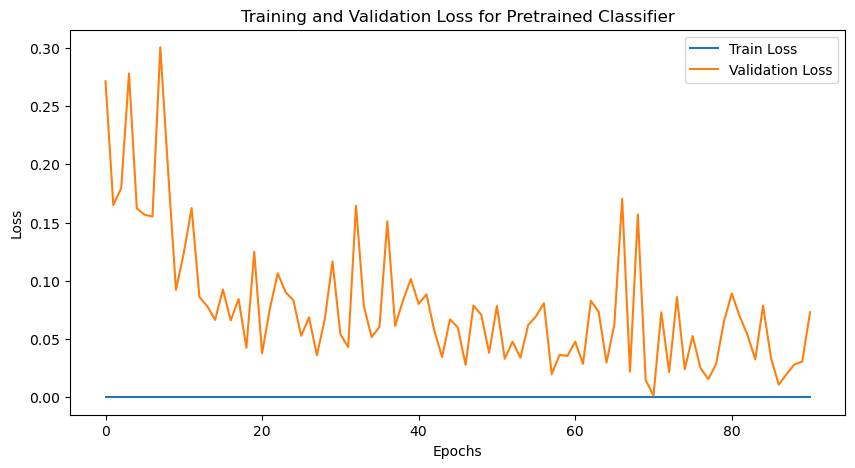

In [400]:
# Visualization of training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(linear_train_losses, label='Train Loss')
plt.plot(linear_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss for Pretrained Classifier')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

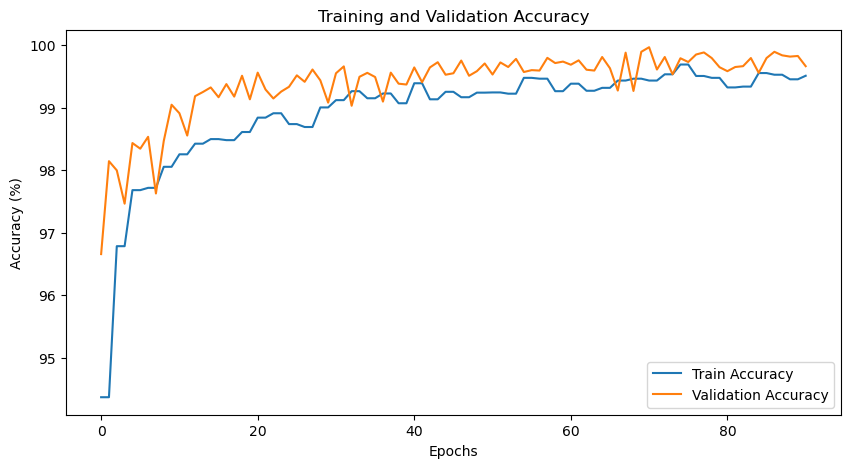

In [401]:
# Visualization of training and validation accuracy
num_epochs = min(len(linear_train_accuracies), len(linear_val_accuracies))
plt.figure(figsize=(10, 5))
plt.plot(linear_train_accuracies[:num_epochs], label='Train Accuracy')
plt.plot(linear_val_accuracies[:num_epochs], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## 4.3 Without Contrastive Pretraining

### 4.3.1 Loading the Data

In [402]:
linear_dataset = datasets.MNIST('./data', train=True, download=True, transform=linear_transforms)
train_size = int((1 - validation_split) * len(linear_dataset))
val_size = len(linear_dataset) - train_size
linear_trainset, linear_valset = torch.utils.data.random_split(linear_dataset, [train_size, val_size])

linear_trainloader = DataLoader(linear_trainset, batch_size=linear_batch_size, shuffle=True)
linear_valloader = DataLoader(linear_valset, batch_size=linear_batch_size, shuffle=False)

# Load the test dataset
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=linear_transforms)
testloader = DataLoader(test_dataset, batch_size=linear_batch_size, shuffle=False)



### 4.3.2 Initialising the Linear Classifier and Optimiser

In [403]:
linear_classifier = nn.Linear(28*28, 10)
linear_learning_rate = 0.01
linear_optimiser = optim.Adam(linear_classifier.parameters(), lr=linear_learning_rate)

### 4.3.3 Linear Classification Without Contrastive Pretraining

In [404]:
comparison_train_losses = []
comparison_val_losses = []
comparison_train_accuracies = []
comparison_val_accuracies = []
comparison_best_val_loss = float('inf')
comparison_patience = 20
comparison_patience_counter = 0

for epoch in range(100):
    linear_classifier.train()

    running_loss = 0.0
    total = 0
    correct = 0

    for batch, data in enumerate(linear_trainloader, 0):
        features, labels = data

        # zero the parameter gradients
        linear_optimiser.zero_grad()

        # forward
        features = features.view(features.size(0), -1)
        outputs = linear_classifier(features)

        # loss
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # backward
        loss.backward()
        running_loss += loss.item()

        # optimise
        linear_optimiser.step()

    comparison_avg_train_loss = running_loss / len(linear_trainloader)
    comparison_train_losses.append(comparison_avg_train_loss)

    # training accuracy
    comparison_train_accuracy = 100 * correct / total
    comparison_train_accuracies.append(comparison_train_accuracy)

    # validation
    linear_classifier.eval()
    comparison_val_loss = 0.0
    comparison_val_correct = 0
    comparison_val_total = 0

    with torch.no_grad():
        for features, labels in linear_valloader:
            features = features.view(features.size(0), -1)
            outputs = linear_classifier(features)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            comparison_val_loss += loss.item()

            # validation accuracy
            _, val_predicted = torch.max(outputs, 1)
            comparison_val_total += labels.size(0)
            comparison_val_correct += (val_predicted == labels).sum().item()

    comparison_avg_val_loss = comparison_val_loss / len(linear_valloader)
    comparison_val_losses.append(comparison_avg_val_loss)

    # validation accuracy
    comparison_val_accuracy = 100 * comparison_val_correct / comparison_val_total
    comparison_val_accuracies.append(comparison_val_accuracy)

    # print statistics
    print(f'Epoch {epoch}, Train Loss: {comparison_avg_train_loss:.4f}, '
          f'Val Loss: {comparison_avg_val_loss:.4f}, '
          f'Train Accuracy: {comparison_train_accuracy:.2f}%, '
          f'Val Accuracy: {comparison_val_accuracy:.2f}%')

    # early stopping
    if comparison_avg_val_loss < comparison_best_val_loss:
        comparison_best_val_loss = comparison_avg_val_loss
        comparison_patience_counter = 0
        #torch.save(linear_classifier.state_dict(), 'best_comparison_model.pth')
    else:
        comparison_patience_counter += 1
        if comparison_patience_counter >= comparison_patience:
            print('Early stopping')
            break

Epoch 0, Train Loss: 0.4303, Val Loss: 0.3611, Train Accuracy: 87.81%, Val Accuracy: 89.68%
Epoch 1, Train Loss: 0.3387, Val Loss: 0.3549, Train Accuracy: 90.59%, Val Accuracy: 89.83%
Epoch 2, Train Loss: 0.3327, Val Loss: 0.3666, Train Accuracy: 91.00%, Val Accuracy: 90.01%
Epoch 3, Train Loss: 0.3308, Val Loss: 0.4150, Train Accuracy: 91.16%, Val Accuracy: 88.94%
Epoch 4, Train Loss: 0.3372, Val Loss: 0.3440, Train Accuracy: 91.00%, Val Accuracy: 90.92%
Epoch 5, Train Loss: 0.3251, Val Loss: 0.3391, Train Accuracy: 91.29%, Val Accuracy: 91.13%
Epoch 6, Train Loss: 0.3261, Val Loss: 0.3913, Train Accuracy: 91.42%, Val Accuracy: 89.97%
Epoch 7, Train Loss: 0.3330, Val Loss: 0.3961, Train Accuracy: 91.27%, Val Accuracy: 89.79%
Epoch 8, Train Loss: 0.3239, Val Loss: 0.4191, Train Accuracy: 91.47%, Val Accuracy: 88.94%
Epoch 9, Train Loss: 0.3346, Val Loss: 0.3766, Train Accuracy: 91.21%, Val Accuracy: 90.66%
Epoch 10, Train Loss: 0.3143, Val Loss: 0.3736, Train Accuracy: 91.62%, Val Accu

In [405]:
# Calculate test set accuracy
linear_classifier.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for features, labels in testloader:
        features = features.view(features.size(0), -1)
        outputs = linear_classifier(features)
        
        # Calculate test accuracy
        _, test_predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (test_predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 90.61%


### 4.3.4 Visualisation

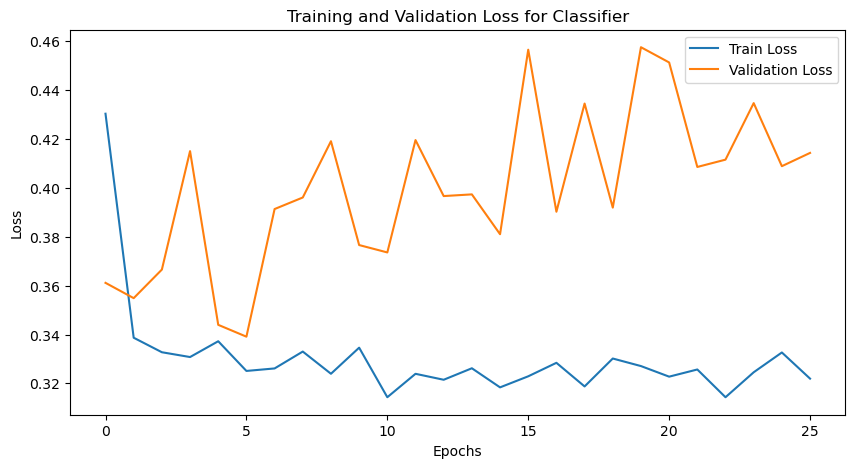

In [406]:
num_epochs = min(len(comparison_train_losses), len(comparison_val_losses))

# Visualization of training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(comparison_train_losses[:num_epochs], label='Train Loss')
plt.plot(comparison_val_losses[:num_epochs], label='Validation Loss')
plt.title('Training and Validation Loss for Classifier')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

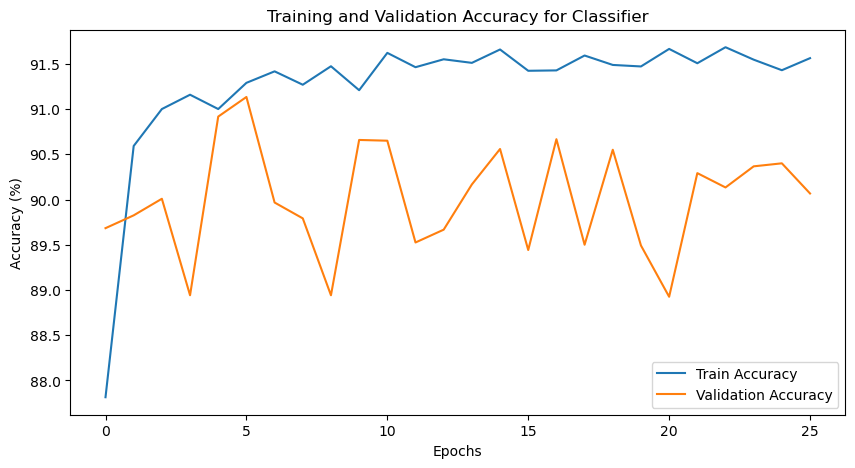

In [407]:
# Visualization of training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(comparison_train_accuracies[:num_epochs], label='Train Accuracy')
plt.plot(comparison_val_accuracies[:num_epochs], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Classifier')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# 5 Results

|                                       | Accuracy |
|---------------------------------------|----------|
| Accuracy With Retraining (Full Data)  | 98.60%   |
| Accuracy With Pretraining (Half Data) | **98.15%**   |
| Accuracy No Pretraining (Full Data)   | 90.61%%   |

1. **Significant Accuracy Improvement:** Pretraining using contrastive learning increased the accuracy of the linear classifier on the same dataset from 90.61% to 98.60%.
2. **Reducing The Need for Labeled Data:** Pretraining allowed the linear classifier to maintain comparable performance (98.60% vs. 98.15%) while being trained on only half of the original training dataset.

### Some Limitations
- **Hyperparameter Tuning:** The study employed fixed hyperparameters without fine-tuning for both pretraining and classification.
- **Focus on Linear Classification:** The evaluation was limited to linear classification, and did not explore more complex tasks like image segmentation or object detection as a downstream task.
- **Simplicity of the Dataset:** The exploration was conducted exclusively on the MNIST dataset, which is rather simple. Future work should explore more complex datasets to validate the generalizability of these findings.